In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import pandas as pd
import json, os, requests
from api_key import api_key

In [3]:
# ---------------
# Starbucks Data
# ---------------

#read Starbucks csv
starbucks_data_path = os.path.join("Source_Files","Starbucks_US_2018_11_12.csv")
starbucks_data = pd.read_csv(starbucks_data_path)

#pull data from Starbucks csv
clean_data = starbucks_data[['city', 'state', 'zip_code']]

SB_states_data = pd.DataFrame(clean_data.groupby('state')['city'].count())
SB_states_data.rename(columns={'city':'Starbucks Stores'}, inplace=True)


In [4]:
# -------------------
# Dunkin Donuts Data
# -------------------


#read the Dunkin json file
with open('dunkinDonuts.json', 'r') as file:
    results = json.load(file)
    data = results['data']
    
# Create dataframe full of relevant information about Dunkin Donuts stores in the US
# First create empty list for State, Zip code, and whether they have almond milk
states,longs,zips,almond = [],[],[],[]


#Go item by item in the list, each item is a dictionary
for i in data:
    states.append(i['state'])
    zips.append(i['postal'])
    longs.append(i['geoJson']['coordinates'][1])
    
    if i['almond']=='Y':
        almond.append(1)
    else:
        almond.append(0)
        


ddDF = pd.DataFrame({
    'State':states,
    'Longitude':longs,
    'Zip Code':zips,
    'Almond':almond
})

totalDunkin = len(data)

#Group the dataframe of individual stores into a summary by state
grpbyState = ddDF.groupby('State')

#empty dataframe for the final results
DDtotals = pd.DataFrame()

DDtotals['Dunkin Stores'] = grpbyState.count()['Zip Code']
DDtotals['Dunkins with Almond Milk'] = grpbyState.mean()['Almond']
#DDtotals['Dunkins with Almond Milk'] = pd.Series(["{0:.0f}%".format(val * 100) for val in DDtotals['Dunkins with Almond Milk']], index = DDtotals.index)
DDtotals['Avg Longitude']= grpbyState.mean()['Longitude']
DDtotals


,Dunkin Stores,Dunkins with Almond Milk,Avg Longitude
State,,,
AK,2,0.000000,-163.414100
AL,41,0.536585,-86.733203
AR,8,0.750000,-93.349532
AZ,96,0.708333,-111.954118
CA,116,0.224138,-118.858061
CO,45,0.555556,-104.985464
CT,524,0.912214,-72.794238
DC,26,0.846154,-77.025123
DE,67,0.119403,-75.576341


In [5]:
# ------------
# Income Data
# ------------

# Request data with API key
api_key = api_key
url = "https://api.stlouisfed.org/geofred/shapes/file?"
query_url = f"https://api.stlouisfed.org/geofred/series/data?series_id=WIPCPI&api_key={api_key}&file_type=json&date=2019-01-01"
response = requests.get(query_url)

# Display API call response
data = response.json()
data_2019 = data["meta"]["data"]["2019"]


# Store state names and personal income to list
state, income, state_abv = [], [], []

# Make a for loop to go through the url response to get each state's personal income
for i in data_2019:
    state.append(i["series_id"][0:2])
    income.append(float(i["value"]))

    # Display personal income per capital into dataframe
personal_income_df = pd.DataFrame({"State": state, "Income": income})


# ----------------
# Population Data
# ----------------

file = "Source_Files/population_by_state_2019.xls"
df = pd.read_excel(file)

population = df[["State", "Population"]]



# -------------------
# Merge Income + Pop
# -------------------

GDPandPOP = pd.merge(population, personal_income_df, how="outer")
GDPandPOP=GDPandPOP.set_index('State')


In [6]:
# ---------------------
# Merge All Dataframes
# ---------------------

# SB_states_data = index of state and one column of total Starbucks Stores in that state
# DDtotals = index of state, columns of total DD stores and % with almond milk
# GDPandPOP = index of state, columns of income and population

stores = pd.merge(SB_states_data,DDtotals, how='outer',left_index=True, right_index=True)
finalDF = pd.merge(GDPandPOP, stores, how='outer', left_index=True, right_index=True)

In [7]:
# Create Dataframe for analysis by income

bins = [30000, 40000, 50000, 60000, 70000, 80000, 90000]
group_labels = ["30k-40k","40k-50k","50k-60k","60k-70k","70k-80k","80k-90k"]
finalDF["Income Bracket"] = pd.cut(finalDF['Income'], bins, labels=group_labels)

stores_by_income = finalDF.groupby("Income Bracket").sum()
stores_by_income = stores_by_income[['Starbucks Stores', 'Dunkin Stores']]
stores_by_income['%Almond'] = finalDF.groupby('Income Bracket').mean()['Dunkins with Almond Milk']
#stores_by_income['%Almond'] = pd.Series(["{0:.0f}%".format(val * 100) for val in stores_by_income['%Almond']], index = stores_by_income.index)

stores_by_income

,Starbucks Stores,Dunkin Stores,%Almond
Income Bracket,,,
30k-40k,33,8.0,0.375000
40k-50k,3173,1271.0,0.495214
50k-60k,5285,3654.0,0.518355
60k-70k,4628,666.0,0.411896
70k-80k,1375,4073.0,0.833813
80k-90k,91,26.0,0.846154


In [8]:
# Create Dataframe for analysis by population

popBins = [0,5000,10000,15000,20000,25000,30000,35000,40000]
popLabels = ['0-5mil','5-10mil','10-15mil','15-20mil','20-25mil','25-30mil','30-35mil','35-40mil']

finalDF['Pop Bracket'] = pd.cut(finalDF['Population'],popBins,labels=popLabels)
byPopDF = finalDF.groupby('Pop Bracket').sum()[['Starbucks Stores','Dunkin Stores']]
byPopDF['%Almond'] = finalDF.groupby('Pop Bracket').mean()['Dunkins with Almond Milk']
#byPopDF['%Almond'] = pd.Series(["{0:.0f}%".format(val * 100) for val in byPopDF['%Almond']], index = byPopDF.index)

byPopDF

,Starbucks Stores,Dunkin Stores,%Almond
Pop Bracket,,,
0-5mil,2304,1513.0,0.551714
5-10mil,4554,3266.0,0.571944
10-15mil,2191,2125.0,0.366778
15-20mil,679,1501.0,0.840773
20-25mil,741,1002.0,0.202595
25-30mil,1148,175.0,0.537143
30-35mil,0,0.0,NaN
35-40mil,2968,116.0,0.224138


In [9]:
finalDF

,Population,Income,Starbucks Stores,Dunkin Stores,Dunkins with Almond Milk,Avg Longitude,Income Bracket,Pop Bracket
AK,733.603,62629.0,51,2.0,0.000000,-163.414100,60k-70k,0-5mil
AL,4907.965,44102.0,88,41.0,0.536585,-86.733203,40k-50k,0-5mil
AR,3020.985,44582.0,61,8.0,0.750000,-93.349532,40k-50k,0-5mil
AZ,7291.843,45975.0,513,96.0,0.708333,-111.954118,40k-50k,5-10mil
CA,39437.610,66745.0,2968,116.0,0.224138,-118.858061,60k-70k,35-40mil
CO,5758.486,61159.0,501,45.0,0.555556,-104.985464,60k-70k,5-10mil
CT,3566.022,77273.0,129,524.0,0.912214,-72.794238,70k-80k,0-5mil
DC,708.253,83111.0,91,26.0,0.846154,-77.025123,80k-90k,0-5mil
DE,976.668,54323.0,32,67.0,0.119403,-75.576341,50k-60k,0-5mil
FL,21492.056,52391.0,741,1002.0,0.202595,-81.464981,50k-60k,20-25mil


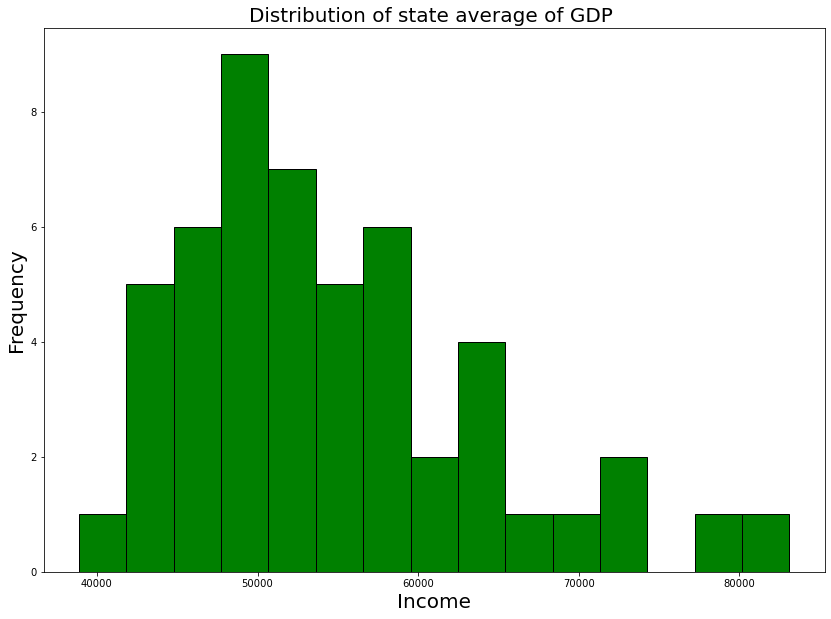

NormaltestResult(statistic=9.092735397753051, pvalue=0.010605657446481509)


In [12]:
plt.figure(figsize=[14, 10])

plt.title(f"Distribution of state average of GDP ", fontsize = 20)
plt.hist(finalDF['Income'], bins = (15), color='g', edgecolor= 'black', align ='mid')
plt.xlabel('Income', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.savefig("Income Vs Frequency.png")
plt.show()
print(sts.normaltest(finalDF['Income']))

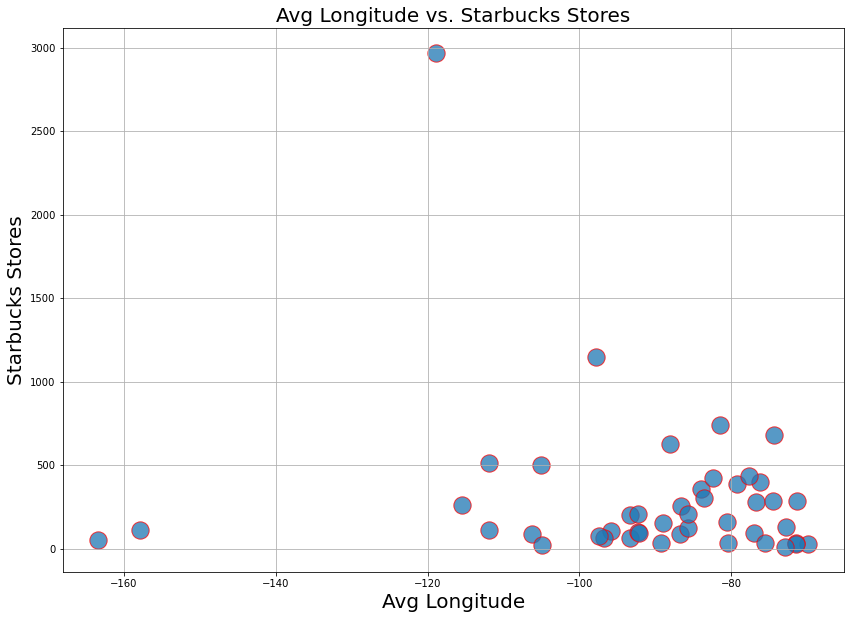

In [11]:
plt.figure(figsize=[14, 10])

plt.scatter(finalDF['Avg Longitude'], finalDF['Starbucks Stores'],marker="o", s=300,alpha=.75, edgecolors="red")

plt.title(f"Avg Longitude vs. Starbucks Stores", fontsize = 20)
plt.ylabel("Starbucks Stores", fontsize = 20)
plt.xlabel("Avg Longitude", fontsize = 20)
plt.savefig("Avg Longitude vs. Starbucks Store, Scatter.png")
plt.grid(True)

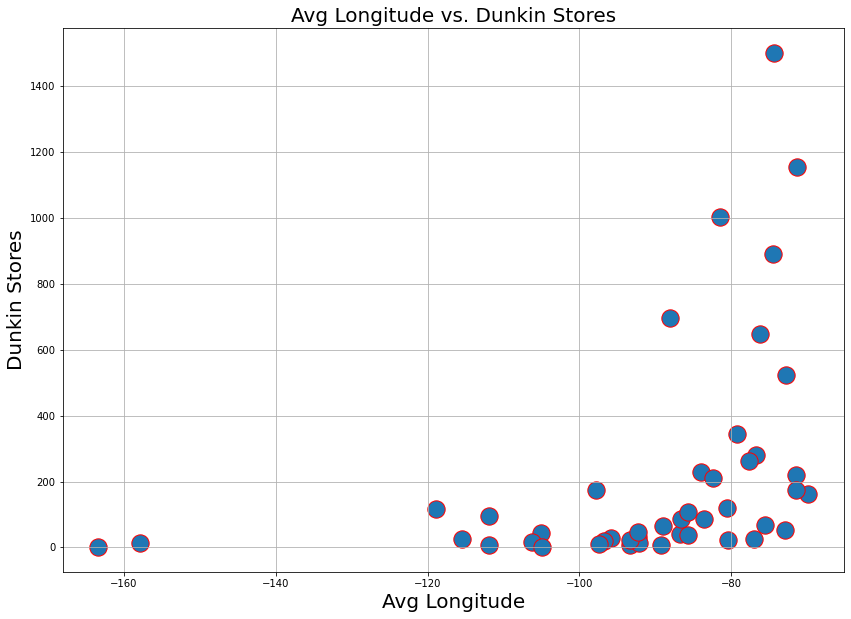

In [28]:
plt.figure(figsize=[14, 10])

plt.scatter(finalDF['Avg Longitude'], finalDF['Dunkin Stores'], marker="o", s=300,alpha=1, edgecolors="red")

plt.title(f"Avg Longitude vs. Dunkin Stores", fontsize = 20)
plt.ylabel("Dunkin Stores", fontsize = 20)
plt.xlabel("Avg Longitude", fontsize = 20)
plt.savefig("Avg Longitude vs. Dunkin Store, Scatter.png")
plt.grid(True)


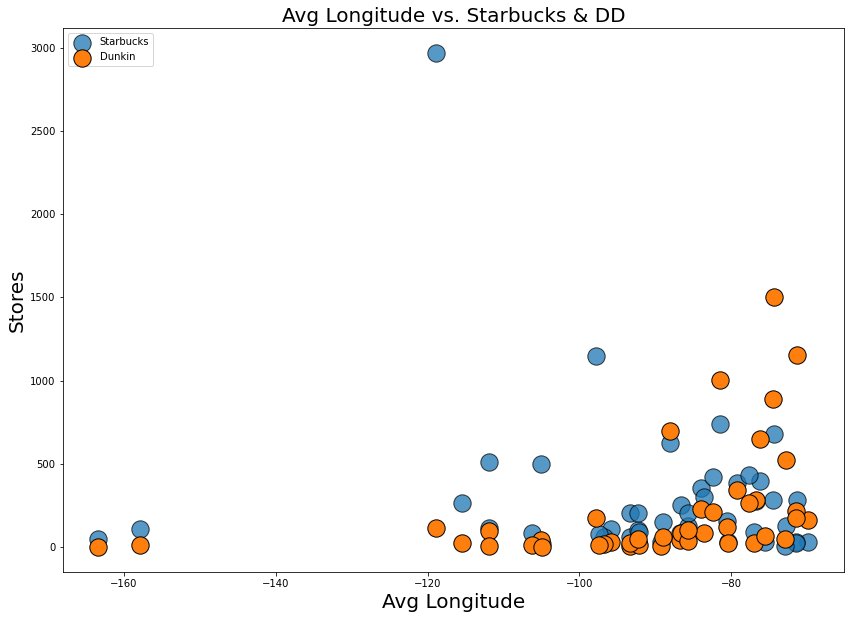

In [29]:
plt.figure(figsize=[14, 10])
#plt = subplot(111)
plt.scatter(finalDF['Avg Longitude'], finalDF['Starbucks Stores'],label = 'Starbucks', marker="o", s=300,alpha=.75, edgecolors = 'black')
plt.scatter(finalDF['Avg Longitude'], finalDF['Dunkin Stores'],label = 'Dunkin', marker="o", s=300,alpha=1, edgecolors="black")
plt.legend(loc = 'upper left');

plt.title(f"Avg Longitude vs. Starbucks & DD", fontsize = 20)
plt.ylabel("Stores", fontsize = 20)
plt.xlabel("Avg Longitude", fontsize = 20)
plt.savefig("Avg Longitude vs. Combined Store, Scatter.png")
#show()

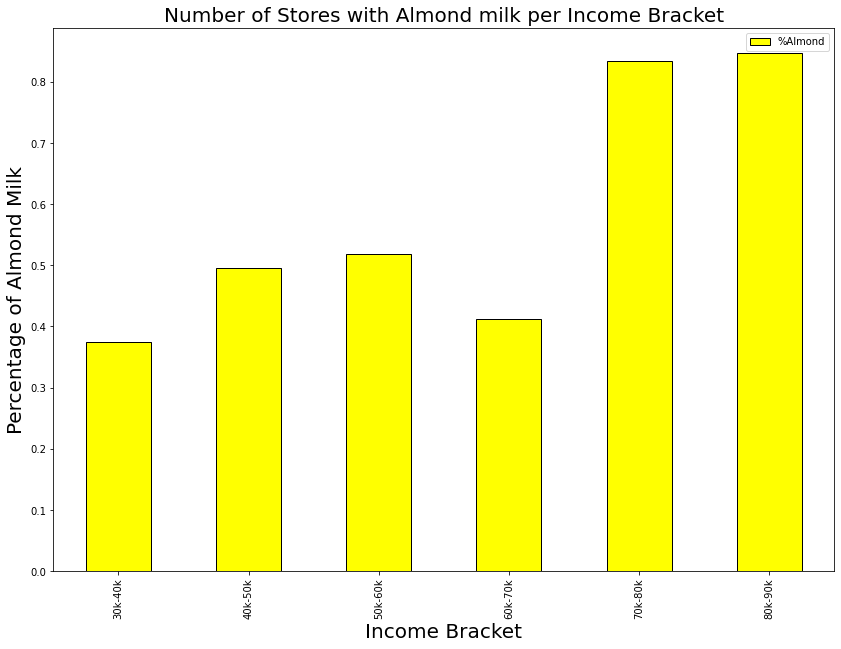

In [30]:
plt.figure(figsize=[14, 10])
chartDF=stores_by_income['%Almond']
#x=finalDF['Income']
#y=finalDF['Dunkins with Almond Milk']


chartDF.plot(kind='bar', color='yellow',edgecolor= 'black', align ='center')
plt.xlabel("Income Bracket", fontsize = 20)
plt.ylabel("Percentage of Almond Milk", fontsize = 20)
plt.title("Number of Stores with Almond milk per Income Bracket", fontsize = 20)
plt.savefig("Number of Stores with Almond milk per Income Bracket.png")
plt.legend()

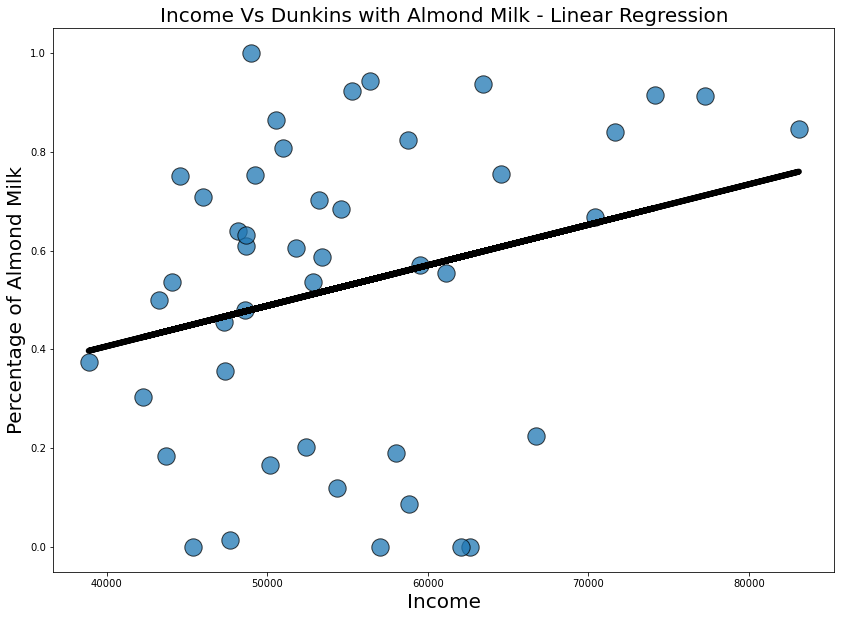

Line Equation: y = 0.0 x + 0.1
The r2 value is 0.0681


In [40]:
from scipy.stats import linregress
import numpy as np
import seaborn as sns
plt.figure(figsize=[14, 10])

fullDF = finalDF.dropna()
#fullDF = (marker="o", s=300,alpha=.75, edgecolors = 'black')
x=fullDF['Income']
y=fullDF['Dunkins with Almond Milk']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = (x * slope) + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y,marker="o", s=300,alpha=.75, edgecolors = 'black')
plt.plot(x,regress_values,"r-", linewidth = 6, color = "black")
plt.xlabel('Income', fontsize = 20)
plt.ylabel('Percentage of Almond Milk', fontsize = 20)
plt.title('Income Vs Dunkins with Almond Milk - Linear Regression', fontsize = 20)
plt.savefig("Income Vs Dunkins with Almond Milk, Linregress.png")
plt.show()
print(f'Line Equation: y = {slope:.1f} x + {intercept:.1f}')
print(f'The r2 value is {rvalue **2:.4f}')

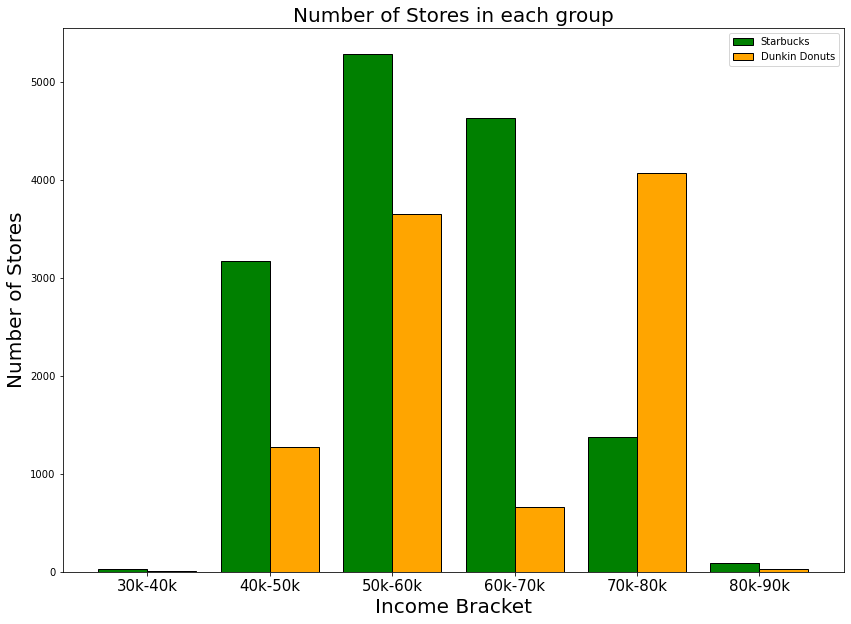

In [32]:

X = ['30k-40k','40k-50k','50k-60k','60k-70k','70k-80k','80k-90k']
Ystarbucks = [33, 3173, 5285, 4628, 1375, 91]
Zdunkin = [8, 1271, 3654, 666, 4073, 26]

plt.figure(figsize=[14, 10])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ystarbucks, 0.4, label = 'Starbucks', color='g',edgecolor= 'black', align ='center')
plt.bar(X_axis + 0.2, Zdunkin, 0.4, label = 'Dunkin Donuts', color='orange',edgecolor= 'black', align ='center')
  
plt.xticks(X_axis, X,fontsize = 15)
plt.xlabel("Income Bracket", fontsize = 20)
plt.ylabel("Number of Stores", fontsize = 20)
plt.title("Number of Stores in each group", fontsize = 20)
plt.legend()
plt.savefig("Income Bracket, Bar.png")
plt.show()

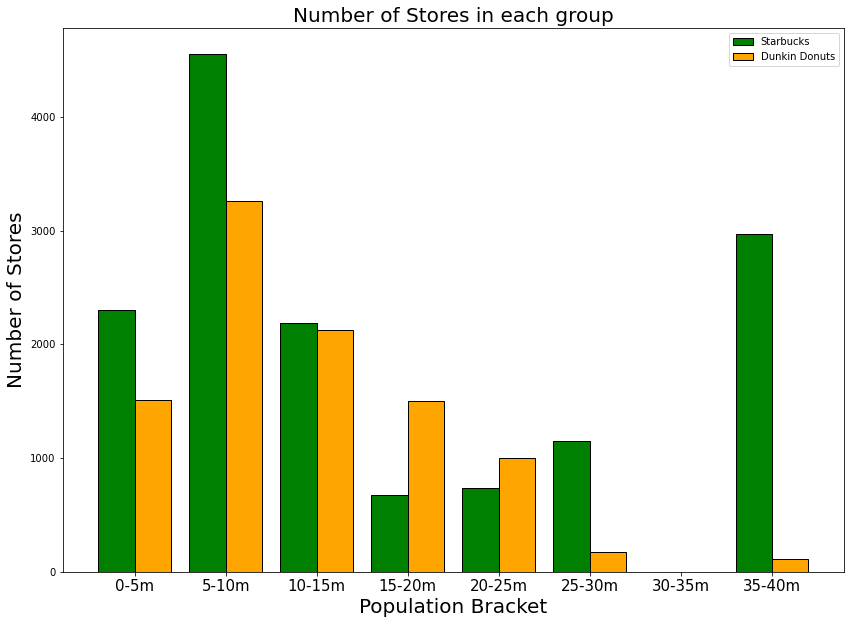

In [33]:

X = ['0-5m','5-10m','10-15m','15-20m','20-25m','25-30m','30-35m','35-40m']
Ystarbucks_pop = [2304, 4554, 2191, 679, 741, 1148, 0, 2968]
Zdunkin_pop= [1513, 3266, 2125, 1501, 1002, 175, 0, 116]

plt.figure(figsize=[14, 10])

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ystarbucks_pop, 0.4, label = 'Starbucks', color='g',edgecolor= 'black', align ='center')
plt.bar(X_axis + 0.2, Zdunkin_pop, 0.4, label = 'Dunkin Donuts', color='orange',edgecolor= 'black', align ='center')

plt.xticks(X_axis, X, fontsize = 15)
plt.xlabel("Population Bracket", fontsize = 20)
plt.ylabel("Number of Stores", fontsize = 20)
plt.title("Number of Stores in each group", fontsize = 20)
plt.legend()
plt.savefig("Population Bracket, Bar.png")
plt.show()

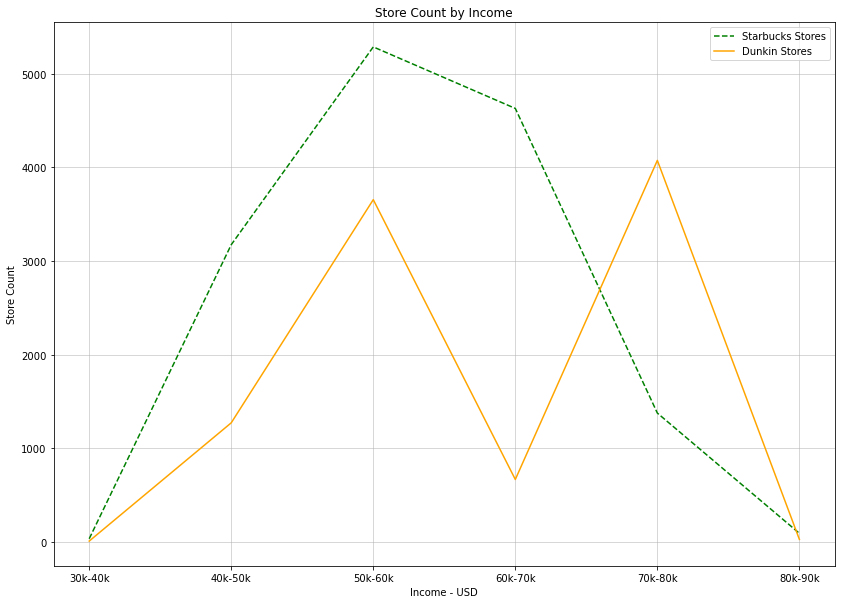

In [34]:
plt.figure(figsize=[14, 10])

chartDF_sb=stores_by_income['Starbucks Stores']
chartDF_dd=stores_by_income['Dunkin Stores']
chartDF_sb.plot(kind='line', color='green', ls='--')
chartDF_dd.plot(kind='line', color='orange')
# Add labels to X and Y axes :: Add title :: Add legend
plt.title('Store Count by Income')
plt.xlabel('Income - USD')
plt.ylabel('Store Count')
plt.legend()
plt.savefig("Income V Store Counts, Line Graph.png")
# Add in a grid for the chart
plt.grid(linewidth=0.5)

In [35]:
s = finalDF["Starbucks Stores"]/finalDF["Population"]
dd = finalDF["Dunkin Stores"]/finalDF["Population"]
finalDF["SPP"] = s
finalDF["DPP"] = dd
F_P = finalDF[["Population", "Income Bracket", "SPP", "DPP"]].sort_values(by=["Income Bracket"])
F_P

,Population,Income Bracket,SPP,DPP
MS,2978.227,30k-40k,0.011080,0.002686
OK,3960.676,40k-50k,0.019694,0.002777
SC,5157.702,40k-50k,0.030828,0.023072
NM,2099.634,40k-50k,0.041912,0.007620
TN,6830.325,40k-50k,0.030306,0.015519
NC,10501.384,40k-50k,0.036662,0.032758
MT,1070.123,40k-50k,0.035510,NaN
WV,1795.263,40k-50k,0.017268,0.012811
MO,6140.475,40k-50k,0.033874,0.007817
MI,9984.795,40k-50k,0.030146,0.008513


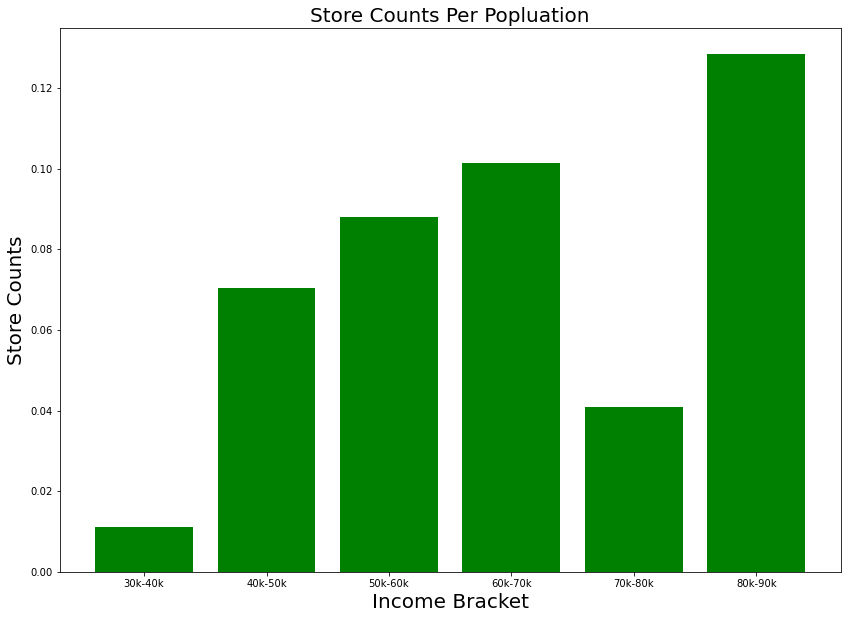

In [36]:
plt.figure(figsize=[14, 10])
x = F_P["Income Bracket"]
y = F_P["SPP"]
plt.bar(x , y, color='g')
plt.xlabel("Income Bracket", fontsize = 20)
plt.ylabel("Store Counts", fontsize = 20)
plt.title("Store Counts Per Popluation", fontsize = 20)
plt.savefig("Store Counts Per Popluation, bar.png")
plt.show()

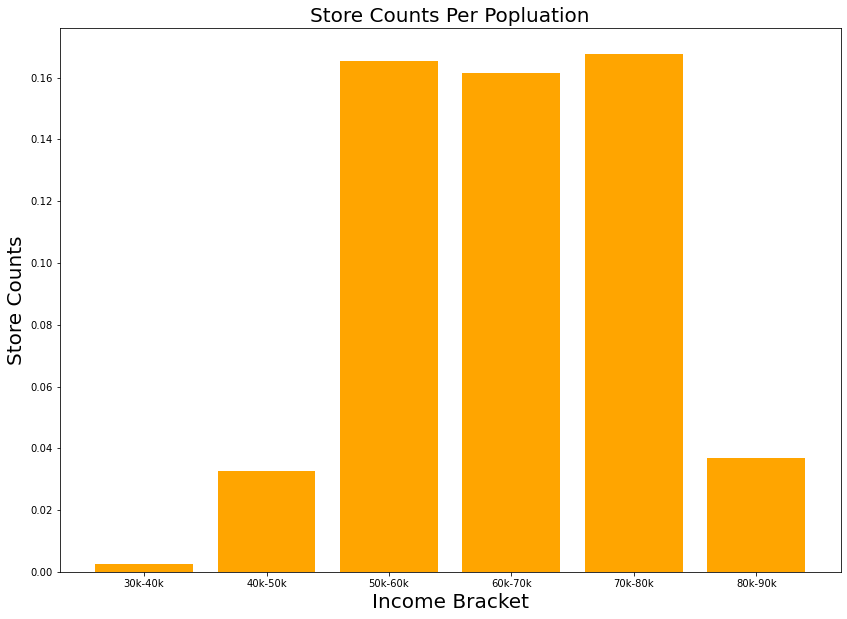

In [37]:
plt.figure(figsize=[14, 10])
x = F_P["Income Bracket"]
z = F_P["DPP"]
plt.xlabel("Income Bracket", fontsize = 20)
plt.ylabel("Store Counts", fontsize = 20)
plt.title("Store Counts Per Popluation", fontsize = 20)
plt.bar(x, z, color='orange')
plt.savefig("Store Counts Per Popluation, bar 2.png")
plt.show()